## Import libraries

In [1]:
import os
import glob
import pickle
from pathlib import Path, PureWindowsPath

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

## Config

In [3]:
class cfg:

    THIS_NOTEBOOK_ID: "FR_t01e01nb04v1"

    #=================================================
    ROOT_TRAINING_RSLTS = os.path.join('..', '..', '..',
                                       "results",
                                       "exp_track",
                                      )

## Utility functions

### flatten_dict()

In [4]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Description
    -----------
        Recursive, inspect inner dict and extract values

    Return: 
    ------
        flat_dictionary: It can be use as one row of a dataframe.
    """
    
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k

        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))

    return dict(items)

## Extract performance during training epochs

In [5]:
#=====================================================================
# READ DATA
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

model_epo_perf = glob.glob(os.path.join(ROOT_DATA, '*', 'perform_acrss_epo', "*", "performance_across_Epochs.pkl"))
model_epo_perf

#=====================================================================
# LOOP across each perforamnce directory
perf_meta = []
for p in model_epo_perf: 

    #_____________
    # Read file
    with open(p, 'rb') as f:
        perf_dct = pickle.load(f)

    #_____________
    # Extract keys
    trnTrackID = perf_dct['track_train_id']
    foldID = perf_dct['fold_id'] # nomenclature: f"seed{random_state in Kfold fun}_fold(n of data splits)
    archID = perf_dct['arch_id']

    perf_meta.append([trnTrackID, 
                      foldID, 
                      archID, 
                      p, 
                     ])

    #_________________________________________________
    # break
#=====================================================================
# Create metadatabase for perforamnces during training epochs during training.
cols = ['track_train_id', 'fold_id', 'arch_id', 'path_perf_dct']
d_prf_meta = pd.DataFrame(perf_meta, columns=cols)
d_prf_meta.head()

,track_train_id,fold_id,arch_id,path_perf_dct
0,TrainTrack_001,seed0_fold0,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_001/perf...
1,TrainTrack_002,seed0_fold0,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_002/perf...


## Extract Params for the whole ML pipeline

In [6]:
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ml_pipe_params_paths = glob.glob(os.path.join(ROOT_DATA, '*', 'ML_pipe_params', "ML_pipe_all_params_*.pkl"))
ml_pipe_params_paths

#=========================================================================
# LOOP across each perforamnce directory
ml_parms_meta = []
for p in ml_pipe_params_paths:

    #________________________
    # Read file 
    with open(p, 'rb') as f:
        ml_pipe_parms_dct = pickle.load(f)
    #________________________
    # Flat dictionary
    flat_dct = flatten_dict(ml_pipe_parms_dct, parent_key='', sep='__')

    
    #________________________
    # Store
    ml_parms_meta.append(flat_dct)

    #________________________
    # break
#----------------------------
# if a dictionary key is missing in some Training Track IDs, due to diff architecture, training, etc
#  -- it needs to be added with Nan values. <<--- Pending
d_ml_pipe_params = pd.DataFrame(ml_parms_meta)
d_ml_pipe_params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   prepro_pipe__pipe_name             2 non-null      object 
 1   prepro_pipe__source_code           2 non-null      object 
 2   architecture__arch_ID              2 non-null      object 
 3   architecture__params__in_channels  2 non-null      int64  
 4   architecture__params__num_classes  2 non-null      int64  
 5   architecture__source_code          2 non-null      object 
 6   split_strategy__cv                 2 non-null      object 
 7   split_strategy__n_split            2 non-null      int64  
 8   split_strategy__cls_col            2 non-null      object 
 9   split_strategy__inst_n_order_col   2 non-null      object 
 10  split_strategy__shuffle_instances  2 non-null      bool   
 11  split_strategy__seed               2 non-null      int64  
 12

## Extract prediction of final training epoch

In [8]:
split_rslts = "test_result.csv" # last training epoch of that training track

ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ypred_rslts_paths = glob.glob(os.path.join(ROOT_DATA, "*", "predictions", "*", split_rslts,))
ypred_rslts_paths

['../../../results/exp_track/TrainTrack_001/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_002/predictions/seed0_fold0/test_result.csv']

In [9]:
tst_rslts = pd.read_csv(ypred_rslts_paths[0])
tst_rslts["y_true"].value_counts()

y_true
2    113
0     84
1     24
Name: count, dtype: int64

In [10]:
tst_rslts["y_true"].shape

(221,)

In [11]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
class_counts

y_true
2    0.511312
0    0.380090
1    0.108597
Name: proportion, dtype: float64

In [12]:
class_counts = tst_rslts["y_true"].value_counts(normalize=True)  # gives class proportions
expected_random_accuracy = (class_counts ** 2).sum()
expected_random_accuracy

0.4177023402469236

## VIZ Performances comparison

In [13]:
d_meta = d_prf_meta.merge(d_ml_pipe_params,
                          how="left",
                          left_on="track_train_id",
                          right_on="training_step__TrackID")
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   track_train_id                     2 non-null      object 
 1   fold_id                            2 non-null      object 
 2   arch_id                            2 non-null      object 
 3   path_perf_dct                      2 non-null      object 
 4   prepro_pipe__pipe_name             2 non-null      object 
 5   prepro_pipe__source_code           2 non-null      object 
 6   architecture__arch_ID              2 non-null      object 
 7   architecture__params__in_channels  2 non-null      int64  
 8   architecture__params__num_classes  2 non-null      int64  
 9   architecture__source_code          2 non-null      object 
 10  split_strategy__cv                 2 non-null      object 
 11  split_strategy__n_split            2 non-null      int64  
 12

In [14]:
metric = 'acc_tst'
#==================================
metric_perf = []
for r, data in d_meta.iterrows():
    
    #---------------------------------------
    # Load performance during training epochs.
    performance_during_training_path = Path(PureWindowsPath(data["path_perf_dct"]))
    with open(performance_during_training_path, 'rb') as f:
        perf_dct = pickle.load(f)
        """
        Keys: 
            ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
             'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
             'lr', 'track_train_id', 'fold_id', 'arch_id']

        """

    #---------------------------------------
    # Extracting metric performance selected during training epochs. 
    metric_perf.append((data["track_train_id"], 
                        perf_dct[metric],
                        data["split_strategy__shuffle_instances"]
                       ),
                       )

    #________________________________________________
    # break
#---------------------------------------------------
cols = ["track_train_id", "metric_vals", "leak"]
d_metric_perf = pd.DataFrame(metric_perf, columns=cols)
d_metric_perf

,track_train_id,metric_vals,leak
0,TrainTrack_001,"[0.7149321266968326, 0.9140271493212669, 0.977...",True
1,TrainTrack_002,"[0.3891402714932127, 0.5520361990950227, 0.493...",False


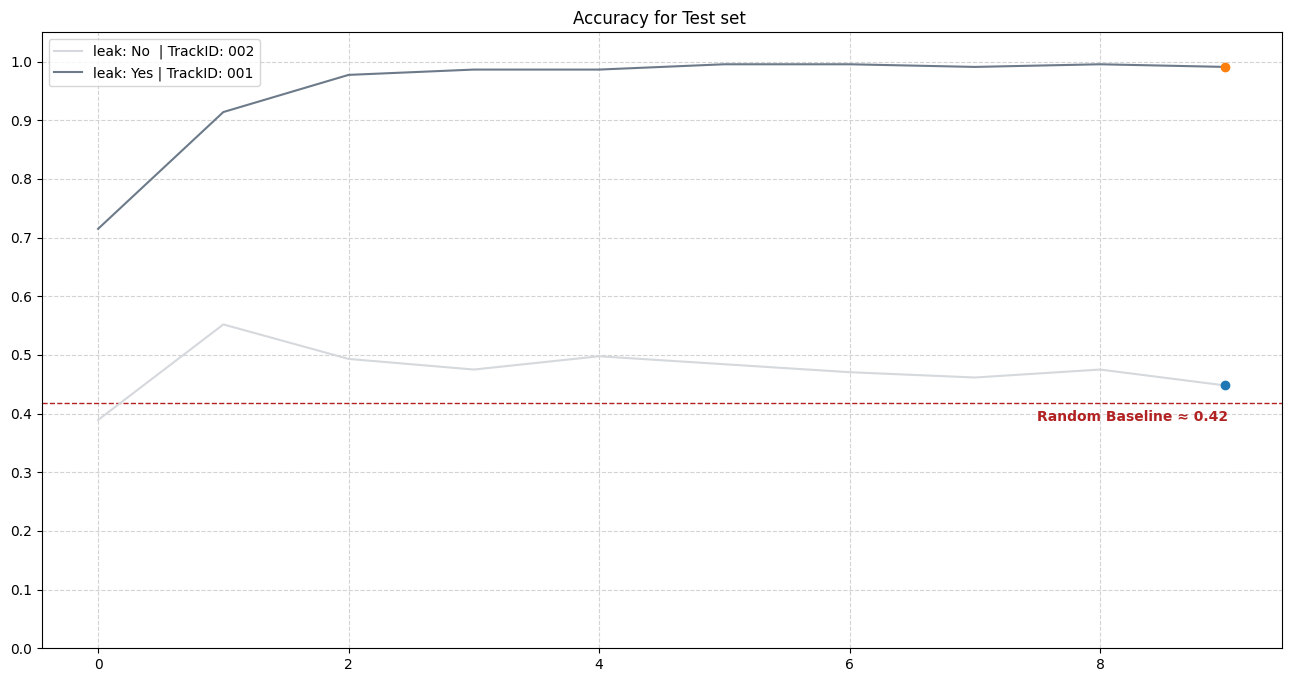

In [15]:
from matplotlib.lines import Line2D
custom_legend_handles1, custom_legend_handles2 = [], []
plt.figure(figsize=(16,8))
for r, data in d_metric_perf.sort_values(by=["leak"]).iterrows():

    #_______________________________________________________
    # Creating series label 
    leakage_exp = data["leak"]
    track = data["track_train_id"]
    
    leak = "Yes" if leakage_exp else "No "
    track = track.split("_")[1]
    serie_label_name = f"leak: {leak} | TrackID: {track}"

    #_______________________________________________________
    serie_values = data["metric_vals"]

    #_______________________________________________________
    color_line = "#6C7A89" if leakage_exp else "#D5D8DC"
    plt.plot(serie_values, label=serie_label_name, color=color_line, zorder=3)

    # last epoch performace
    sc = plt.scatter(len(serie_values) - 1, serie_values[-1], zorder=3)
    #----------------------------

    legend_label = (
        f'{serie_label_name}: '
        f'$\u2015$'  # Unicode for horizontal line
        f' (line)  '
        f'$\u25CF$'  # Unicode for filled circle with this color : sc.get_facecolor()[0]
        f' (marker)' 
    )
    custom_legend_handles1.append(Line2D(
        [0], [0],
        color=color_line,
        # marker='o',
        # markerfacecolor=sc.get_facecolor()[0],
        # label=f'{serie_label_name}: line + marker'
        label=legend_label,
    ))
    # custom_legend_handles2.append(Line2D(
    #     [0], [0],
    #     # color=color_line,
    #     marker='o',
    #     # markerfacecolor=sc.get_facecolor()[0],
    #     # label=f'{serie_label_name}: line + marker'
    #     label=legend_label,
    # ))




    #_______________________________________________________
    # break
#-----------------------------------------------------------
plt.axhline(expected_random_accuracy, color='firebrick', linestyle='--', linewidth=1, 
            # label='Random Baseline', 
           )
# Annotate the line
plt.text(
    x=7.5, 
    y=expected_random_accuracy - 0.03, 
    s=f'Random Baseline ≈ {expected_random_accuracy:.2f}',
    color='firebrick',
    fontsize=10,
    fontweight='bold'
)

plt.title("Accuracy for Test set ")
# plt.legend(handles=[(custom_legend_handles1, custom_legend_handles2)])
# plt.legend(handles=custom_legend_handles1)
leg = plt.legend()
plt.grid(color='lightgray', linestyle="--", zorder=0 )
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.ylim(0,1.05)
plt.show()

In [17]:
print(dir(leg))

['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alignment', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_cm_set', '_custom_handler_map', '_default_handler_map', '_different_canvas', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_fully_clipped_to_axes', '_get_anchored_bbox', '_get_loc', '_gid', '_in_layout', '_init_legend_box', '_internal_update', '_label', '_legend_box', '_legend_handle_box', '_legend_title_box', '_loc', '_loc_real', '_loc_used_default', '_mode', '_mouseover', '_ncols', '_outside_loc', '_parent_figure', '_path_effects', '_picke